# Laboratorio 3

In [1]:
#---------------------------------------------------------------------------------
# Project    : Laboratorio N°3
# Authors    : Mugni Juan Mauricio
# Affiliation: UNC
# E-mail     : mauricio.mugni@mi.unc.edu.ar
#---------------------------------------------------------------------------------

Instalación del programa para interactuar con dispositivos diseñados por Analog Device con un alto grado de abstracción, mediante el lenguaje Python:

In [2]:
#! pip install pyadi-iio #Una vez instalado descomentar #El signo admiración es parte de la sentencia!

Librería de Python para hacer uso del software. Me permite utilizar objetos para reconfigurar el hardware.

In [3]:
import adi

Se instalan las siguientes librerías:

In [4]:
#! pip install matplotlib               #El signo admiración es parte de la sentencia!
#! pip install scikit-dsp-comm          #El signo admiración es parte de la sentencia!
#! pip install scikit-commpy            #El signo admiración es parte de la sentencia!

Agregamos librerias

In [5]:
#------------------------------- Librerias ------------------------------- 
import numpy as np
import matplotlib.pyplot as plt

Se crea el objeto SDR y se lo víncula con el dispositivo que se encuentra en la dirección proporcionada por la variable URI

In [219]:
Uri = "ip:192.168.1.33" # "ip:192.168.1.35" "ip:192.168.1.34" "ip:192.168.1.33" "ip:192.168.1.32"
sdr = adi.Pluto(Uri)  

Definimos el número de muestras:

In [220]:
nSamples     = 2**20                                   #Número de muestras -> tamaño del buffer
samplingRate = 2.0e6                                   #Promedio de muestas -> muestras por segundo

Generamos una señal (hipótesis) binaria compleja que se puede modificar, a través de la variable `ref`, y definimos la probabilidad de ocurrencia de los valores binarios: 

In [221]:
ref = 0.5                                                        # Probabilidad de ocurrencia

z = np.random.uniform(size=nSamples)                             # Generador uniforme de números aleatorios
x = [1 if z[i]>ref else 0 for i in range(len(z))]                # Completo el vector binario de acuerdo a la probabilidad de ocurrencia 

txSignal = (2*np.repeat(x, 2**4)-1)+1j*(2*np.repeat(x, 2**4)-1)  # Señal binaria compleja

## Gráfica temporal de la señal

En este punto se busca graficar la parte real e imaginaria de la señal que se va a transmitir, para ello se define la siguiente función:

In [47]:
def plotSignal(signal):
#------------------------------- Transmitted I component ------------------------------- 
# Plot time domain
    plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(2,1,1)
    plt.plot(np.real(signal))
    plt.xlabel('n')
    plt.ylabel('Amplitud')
    plt.title('Componente en fase de la señal')
    plt.grid()
#------------------------------- Transmitted Q component -------------------------------
# Plot time domain
    plt.subplot(2,1,2)
    plt.plot(np.imag(signal))
    plt.xlabel('n')
    plt.ylabel('Amplitud')
    plt.title('Componente en cuadratura de la señal')
    plt.grid()
    plt.show()

Graficamos la señal:

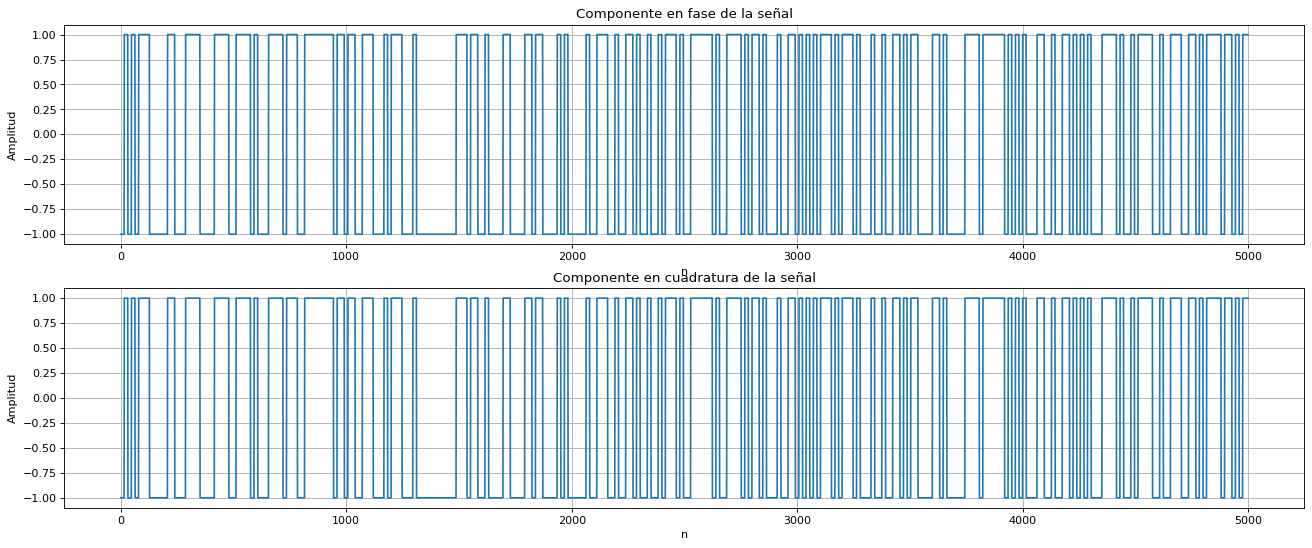

In [48]:
plotSignal(txSignal[0:5000])

## Grafica en frecuencia de la señal

Se pretende graficar el espectro de la densidad de potencia, definimos la siguiete función:

In [49]:
def plotSpect(signal,samplingRate):
    plt.subplots(figsize=(15, 3))
    plt.grid()
    plt.title("Power Spectral Density")
    plt.psd(signal, len(signal), samplingRate, color='C1')
    plt.show()

Graficamos la densidad espectral:

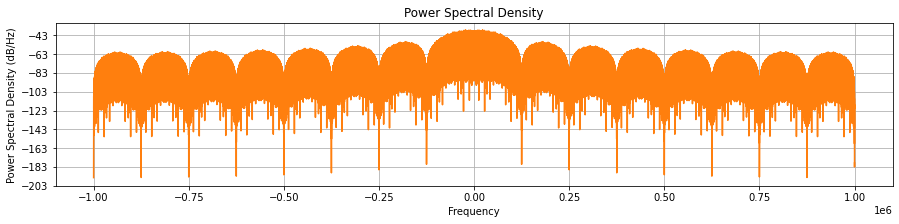

In [50]:
plotSpect(txSignal,samplingRate)

## Histograma de la señal

Graficamos el histograma de la señal para ver las componenentes de la señal.

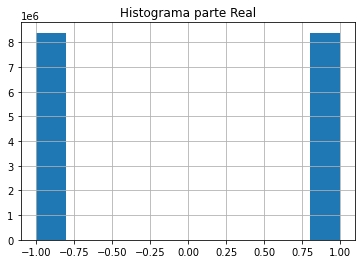

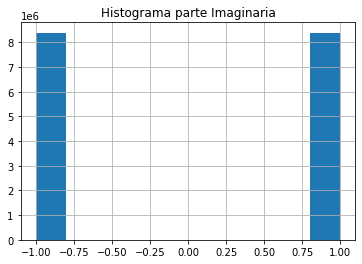

In [51]:
plt.hist(txSignal.real)
plt.grid()
plt.title("Histograma parte Real")
plt.show()

plt.hist(txSignal.imag)
plt.title("Histograma parte Imaginaria")
plt.grid()
plt.show()

## Observación de la grafica

Se esta generando una señal a partir de un vector que toma valores aleatorios entre $1$ y $0$. Definida esta probabilidad por una distribución uniforme y una referencia. La señal toma valores entre $1$ y $-1$. 
Lo que se puede ver en las gráficas es lo siguiente:
-  Analizando el dominio del tiempo, notamos que tanto la señal real como imaginaria forman una señal cuadrada de amplitud $1$ y $-1$, con distintas frecuencias. Toma valores entre $1$ y $-1$ con la misma probabilidad.
- Analizando el dominio de la frecuencia, se ve que tiene una densidad espectral alta, ya que abarca todas las componentes de frecuencia. Desde las más bajas hasta $1MHz$, eso es lo que se llega ver pero frecuencias más altas tambien debe tener.
- Se ven dos columnas centradas en $1$ y $-1$ respectivamente con la misma frecuencia. Representando la equiprobabilidad.

## Transmisión y Recepción 

### Configuración SDR

Limpiamos el buffer primero para evitar datos anteriores.

In [222]:
sdr.tx_destroy_buffer()

Configuramos el SDR de la siguiente manera:

In [223]:
Loopback         = 0             # 0=Disabled, 1=Digital loopback, 2=Retransmiter
SamplingRate     = 521e5          # Sample rate RX and TX paths[Samples/Sec] #Promedio de muestas                                   

# Tx
TxLOFreq         = 954e6         # Carrier frequency of TX path [Hz]
TxAtten          = -35           # Attenuation applied to TX path, valid range is -89 to 0 dB [dB]
TxRfBw           = 2.0e6         # Bandwidth of front-end analog filter of TX path [Hz]
RxBufferSize     = nSamples      # Depend on the length of the transmit signal. Maximum tx buffer size 2**24[samples] #Número de muestras
tx_cyclic_buffer = True

#Rx
RxLOFreq         = TxLOFreq      # Carrier frequency of RX path [Hz]
GainControlModes = "manual"      # Receive path AGC Options: slow_attack, fast_attack, manual
RxHardwareGain   = 70            # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'    
RxRfBw           = TxRfBw        # Bandwidth of front-end analog filter of RX path [Hz] 
RxBufferSize     = len(txSignal) # Rx Buffer size. Maximun value 2**28 [Samples]

sdr.loopback        = Loopback      # Lazo de retorno

sdr.sample_rate = SamplingRate

sdr.tx_rf_bandwidth = int(TxRfBw)   # Bandwidth of front-end analog filter of TX path [Hz]
sdr.rx_rf_bandwidth = int(RxRfBw)   # Bandwidth of front-end analog filter of RX path [Hz] 

sdr.tx_hardwaregain_chan0 = TxAtten
sdr.rx_hardwaregain_chan0 = RxHardwareGain
sdr.gain_control_mode_chan0 = GainControlModes

sdr.tx_lo = int(TxLOFreq) # Carrier frequency of TX path [Hz]
sdr.rx_lo = int(RxLOFreq) # Carrier frequency of RX path [Hz]

sdr.rx_buffer_size   = RxBufferSize
sdr.tx_cyclic_buffer = tx_cyclic_buffer
#sdr._ctrl.context.set_timeout(0)    # <- disable timeout if you want to use large buffer size

### Transmisión

Se transmite:

In [224]:
#------------------------------- Transmitter ------------------------------- 
sdr.tx(txSignal*(2**15-1)) # The PlutoSDR expects samples to be between -2^15-1 and +2^15-1, not -1 and +1 like some SDRs

### Recepción

Para evitar capturar la señal en algún estado transitorio inicial y para eliminar del buffer del receptor muestras de señales tomadas con anterioridad, ejecuta lo siguiente antes de recibir la señal:

In [225]:
#Clear RX Buffer
for i in range(10):
    raw_data = sdr.rx()
    
#------------------------------- Receiver ------------------------------- 
rxSignal = sdr.rx()

Normailizamos la señal recibida para que tenga potencia unitaria.

In [226]:
desviacionReal = rxSignal.real.std()
print("Desviacion Real: ", desviacionReal)

desviacionImag = rxSignal.imag.std()
print("Desviacion Imaginaria: ",desviacionImag)

rxSignalRealN = rxSignal.real/desviacionReal
rxSignalImagN = rxSignal.imag/desviacionImag

Desviacion Real:  1862.4797579499498
Desviacion Imaginaria:  1820.0809936618532


### Grafica temporal de la señal recibida

Se gafica la señal recibida en el dominio del tiempo, vemos su parte real e imaginaria:

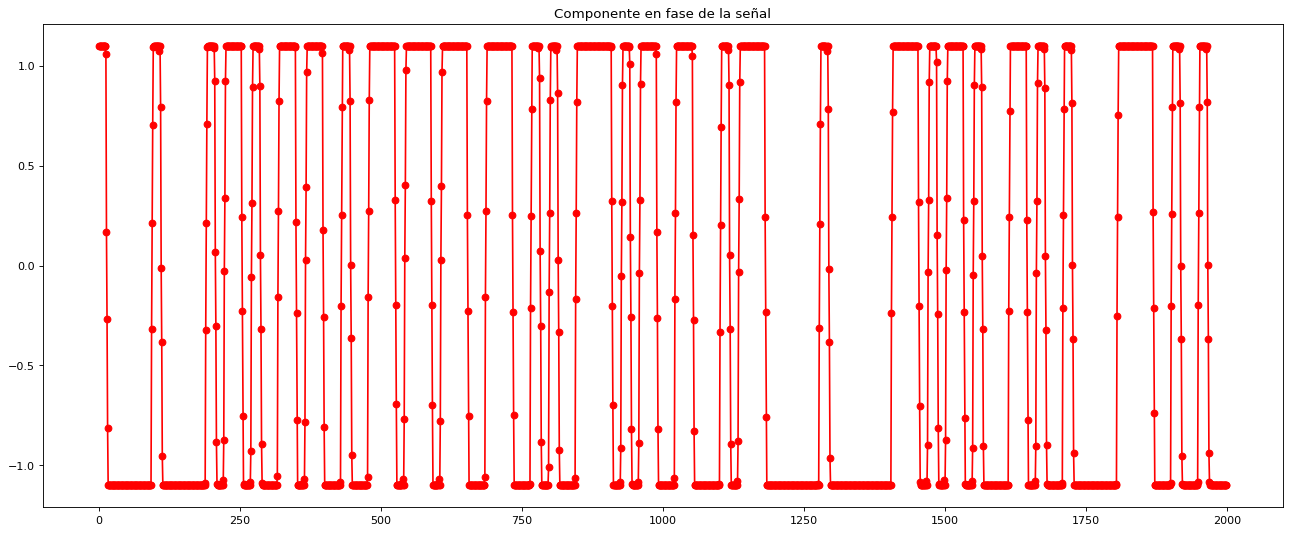

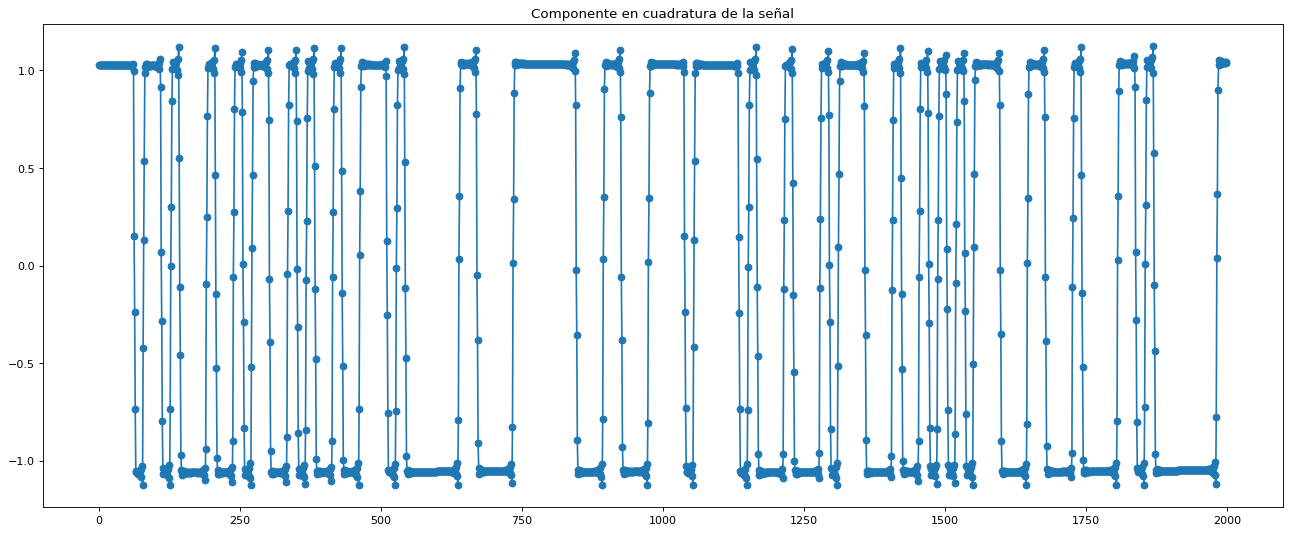

In [227]:
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(rxSignalRealN[2000:4000],marker="o", color='r')
plt.title("Componente en fase de la señal")
plt.show()

plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(rxSignalImagN[0:2000],marker="o")
plt.title("Componente en cuadratura de la señal")
plt.show()

### Grafica en frecuencia de la señal 

Se grafica la densidad espectral de potencia de la señal recibida

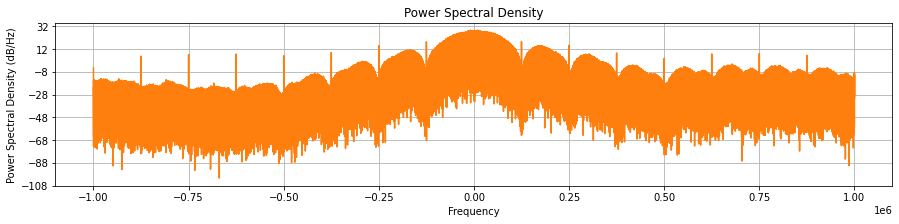

In [228]:
plotSpect(rxSignal,samplingRate)

### Histograma de la señal recibida

Realizamos el histograma de la señal normalizada, tanto de la parte real como imaginaria:

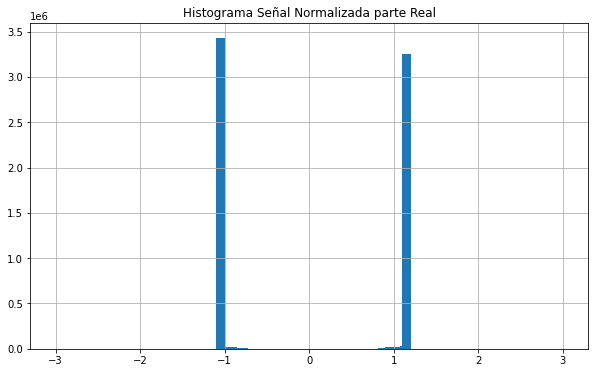

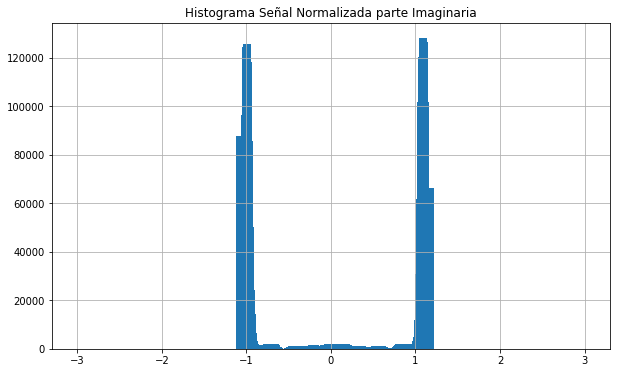

In [229]:
plt.figure(figsize=(10, 6))
plt.hist(rxSignalRealN, bins=10000, range=(-3, 3), width=0.1)
plt.title("Histograma Señal Normalizada parte Real")
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(rxSignalImagN, bins=10000, range=(-3, 3), width=0.1)
plt.title("Histograma Señal Normalizada parte Imaginaria")
plt.grid()
plt.show()

### Observación de la grafica

A partir de las gráficas podemos deducir lo siguiente:
- De la grafica con respecto al tiempo, en la parte real estamos viendo una onda cuadrada, de igual manera con la parte imaginaria. Donde su periodo es aleatorio y toma los valores de $\{ 1, -1 \}$. Para obtener esta gráfica fue necesario modificar la atenuación del SDR, ya que no se llegaba a observar señales cuadradas.
- De la grafica de densidad espectral, podemos ver como estamos recibiendo una señal de mayor potencia de la que se envío. Y como esta mantiene de forma aproximada, se aprecia una perdida de armónicas o frecuencias fundamentales, por lo que no se llegan a transmitir todas las frecuencias.
- Y del histograma podemos apreciar que el ruido se encuentra centrado en $1$ y $-1$, ya que este tiene media cero.  Aquí tambien fue necesario modificar la atenuación, no se llegaba a apreciar el comportamiento y lo único que se veía era ruido, es decir, una campa centrada en el origen.

## Aumento de la potencia transmitida

Limpiamos el buffer del transmisor, para que transmita con otra configuración: 

In [140]:
sdr.tx_destroy_buffer()
sdr.tx_cyclic_buffer = tx_cyclic_buffer

Configuramos el SDR de la siguiente manera:

In [78]:
TxAtten          = -10              # Attenuation applied to TX path, valid range is -89 to 0 dB [dB]
sdr.tx_hardwaregain_chan0 = TxAtten  

### Transmisión

Transmitimos

In [79]:
#------------------------ Transmitter ------------------------------- 
sdr.tx(txSignal*(2**15-1)) # The PlutoSDR expects samples to be between -2^15-1 and +2^15-1, not -1 and +1 like some SDRs

### Recepción
Recibimos la señal nuevamente:

In [80]:
#Clear RX Buffer
for i in range(15):
    raw_data = sdr.rx()
    
#------------------------------- Receiver ------------------------------- 
rxSignal = sdr.rx()

### Normalización
Normailizamos la señal recibida para que tenga potencia unitaria.

In [81]:
desviacionReal = rxSignal.real.std()
print("Desviacion Real: ", desviacionReal)

desviacionImag = rxSignal.imag.std()
print("Desviacion Imaginaria: ",desviacionImag)

rxSignalRealN = rxSignal.real/desviacionReal
rxSignalImagN = rxSignal.imag/desviacionImag

Desviacion Real:  1865.2761275187256
Desviacion Imaginaria:  1822.944023929543


### Grafica temporal de la señal recibida
Se gafica la señal recibida en el dominio del tiempo, vemos su parte real e imaginaria:

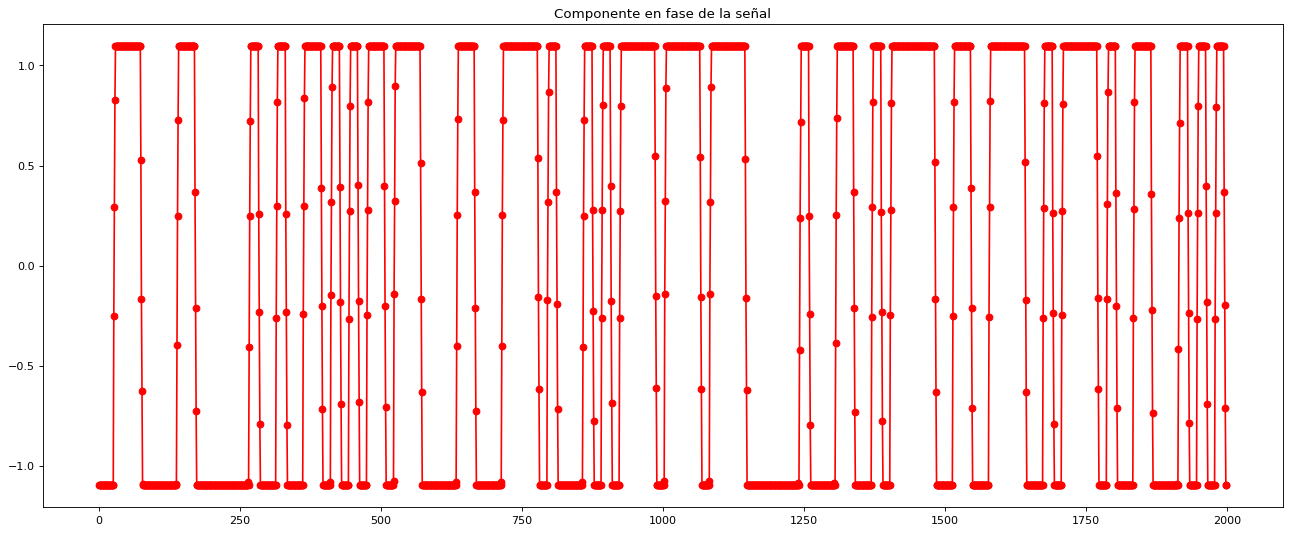

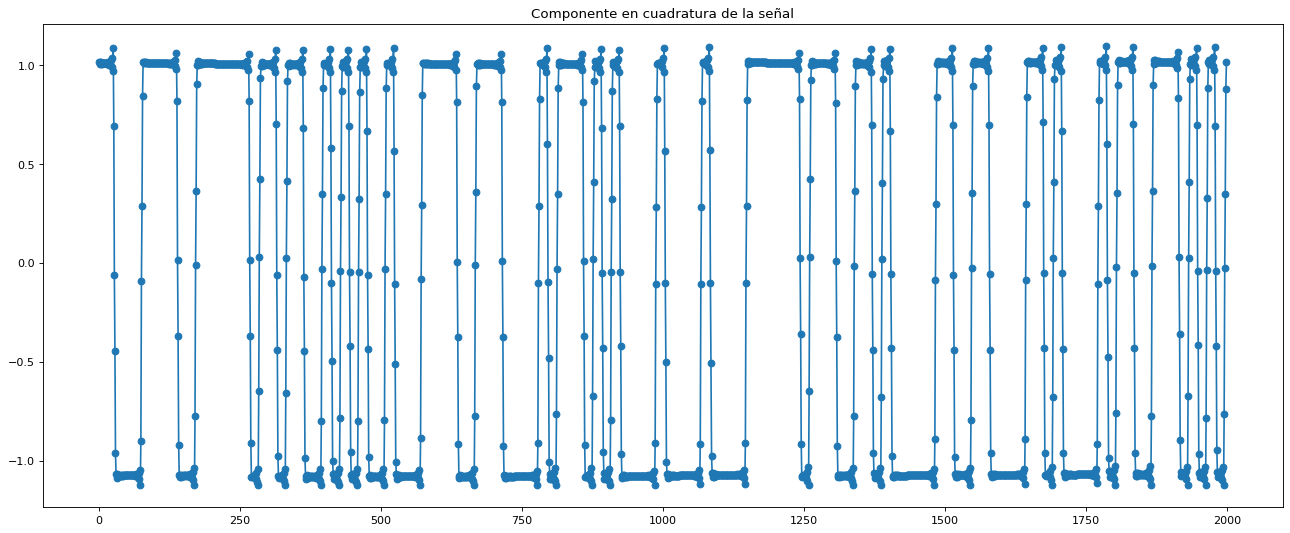

In [82]:
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(rxSignalRealN[0:2000],marker="o", color='r')
plt.title("Componente en fase de la señal")
plt.show()

plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(rxSignalImagN[0:2000],marker="o")
plt.title("Componente en cuadratura de la señal")
plt.show()

### Grafica en frecuencia de la señal recibida
Se grafica la densidad espectral de potencia de la señal recibida

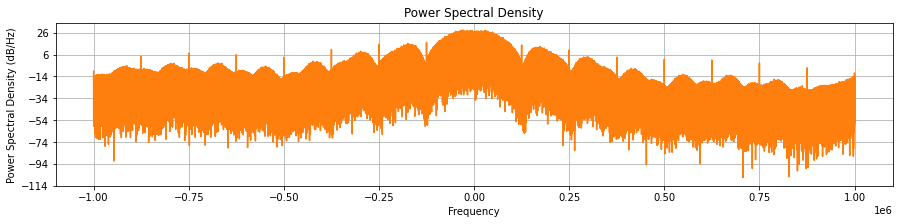

In [83]:
plotSpect(rxSignal,samplingRate)

### Histograma de la señal recibida
Realizamos el histograma de la señal normalizada, tanto de la parte real como imaginaria:

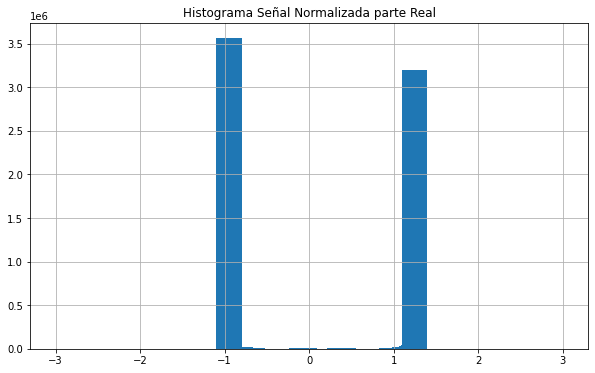

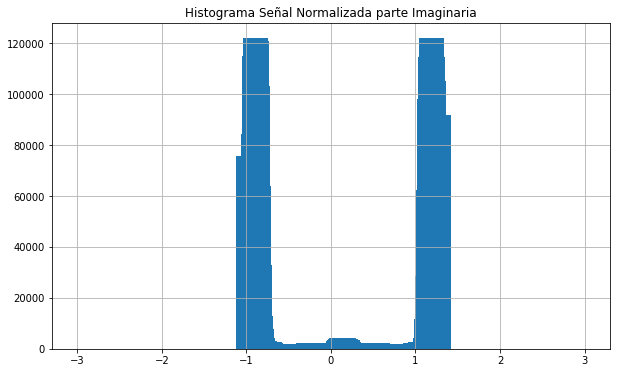

In [89]:
plt.figure(figsize=(10, 6))
plt.hist(rxSignalRealN,bins=10000,width=0.3,range=(-3,3))
plt.title("Histograma Señal Normalizada parte Real")
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(rxSignalImagN,bins=10000,width=0.3,range=(-3,3))
plt.title("Histograma Señal Normalizada parte Imaginaria")
plt.grid()
plt.show()

### Coclusiones al cambiar la potencia

A partir de las gráficas podemos deducir lo siguiente:
- De la grafica con respecto al tiempo, en la parte real estamos viendo una onda cuadrada, de igual manera con la parte imaginaria. Donde su periodo es aleatorio y toma los valores de $\{ 1, -1 \}$
- De la grafica de densidad espectral, podemos ver como estamos recibiendo una señal de mayor potencia de la que se envío, y de la antes recivida. Esta se mantiene de forma aproximada, y se aprecia una perdida de armónicas o frecuencias fundamentales, por lo que no se llegan a transmitir todas las frecuencias.
- Y del histograma podemos apreciar como el ruido se encuentra centrado en $-1$ y $1$ con un mayor ancho que en el caso anterior, es decir, de manera más definida.

## Cambio en el nivel de decisión

Para esto se cambio el `threshold`a $0.3$

Generamos una nueva señal (hipótesis) binaria compleja que se puede modificar, a través de la variable `ref`, y definimos la probabilidad de ocurrencia de los valores binarios: 

In [153]:
ref = 0.3                                                        # Probabilidad de ocurrencia

z = np.random.uniform(size=nSamples)                             # Generador uniforme de números aleatorios
x = [1 if z[i]>ref else 0 for i in range(len(z))]                # Completo el vector binario de acuerdo a la probabilidad de ocurrencia 

txSignal = (2*np.repeat(x, 2**4)-1)+1j*(2*np.repeat(x, 2**4)-1)  # Señal binaria compleja

### Gráfica temporal de la señal

En este punto se busca graficar la parte real e imaginaria de la señal que se va a transmitir, para ello se define la siguiente función:

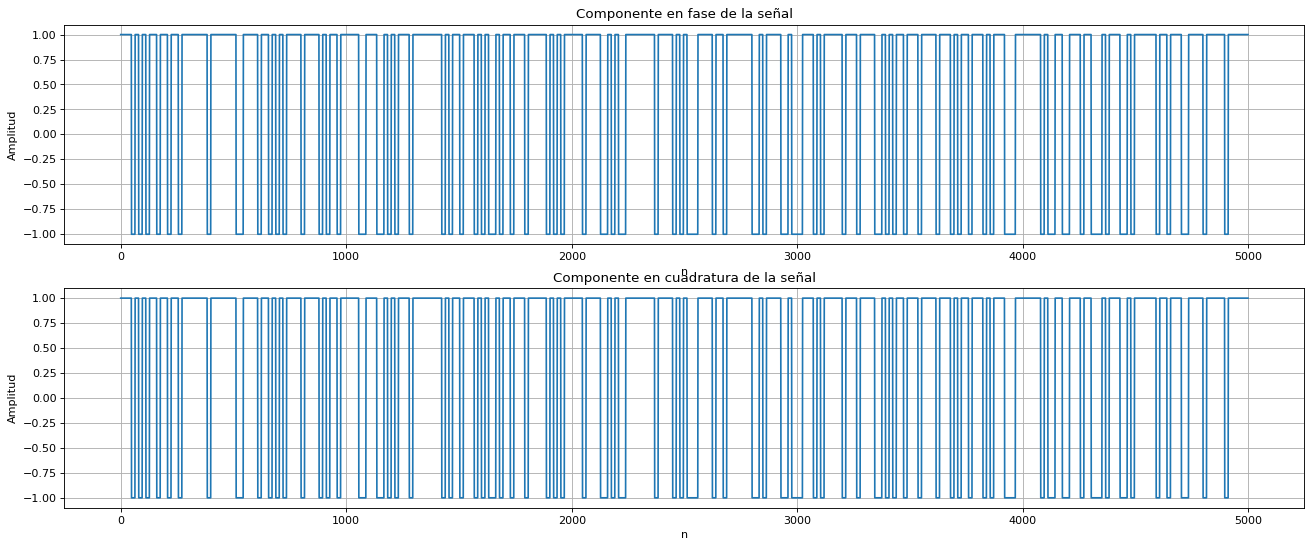

In [154]:
plotSignal(txSignal[0:5000])

### Grafica en frecuencia de la señal

Graficamos la densidad espectral:

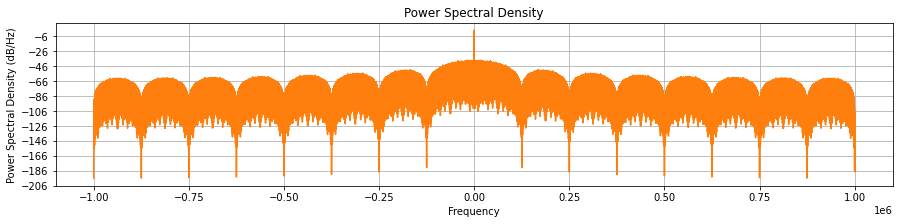

In [155]:
plotSpect(txSignal,samplingRate)

### Histograma de la señal

Graficamos el histograma de la señal para ver las componenentes de la señal.

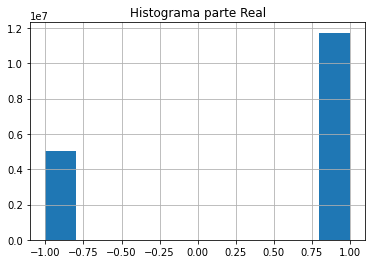

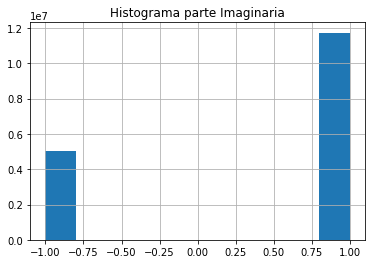

In [156]:
plt.hist(txSignal.real)
plt.grid()
plt.title("Histograma parte Real")
plt.show()

plt.hist(txSignal.imag)
plt.title("Histograma parte Imaginaria")
plt.grid()
plt.show()

### Transmisión

Limpiamos el buffer del transmisor, para que transmita con otra configuración: 

In [165]:
sdr.tx_destroy_buffer()
sdr.tx_cyclic_buffer = tx_cyclic_buffer

Configuramos el SDR de la siguiente manera:

In [166]:
TxAtten          = -35             # Attenuation applied to TX path, valid range is -89 to 0 dB [dB]
sdr.tx_hardwaregain_chan0 = TxAtten 

Transmitimos

In [167]:
#------------------------ Transmitter ------------------------------- 
sdr.tx(txSignal*(2**15-1)) # The PlutoSDR expects samples to be between -2^15-1 and +2^15-1, not -1 and +1 like some SDRs

### Recepción

Recibimos la señal nuevamente:

In [168]:
#Clear RX Buffer
for i in range(10):
    raw_data = sdr.rx()
    
#------------------------------- Receiver ------------------------------- 
rxSignal = sdr.rx()

### Normalización
Normailizamos la señal recibida para que tenga potencia unitaria.

In [169]:
desviacionReal = rxSignal.real.std()
print("Desviacion Real: ", desviacionReal)

desviacionImag = rxSignal.imag.std()
print("Desviacion Imaginaria: ",desviacionImag)

rxSignalRealN = rxSignal.real/desviacionReal
rxSignalImagN = rxSignal.imag/desviacionImag

Desviacion Real:  1212.261078050677
Desviacion Imaginaria:  1434.2962867137874


### Grafica temporal de la señal recibida
Se gafica la señal recibida en el dominio del tiempo, vemos su parte real e imaginaria:

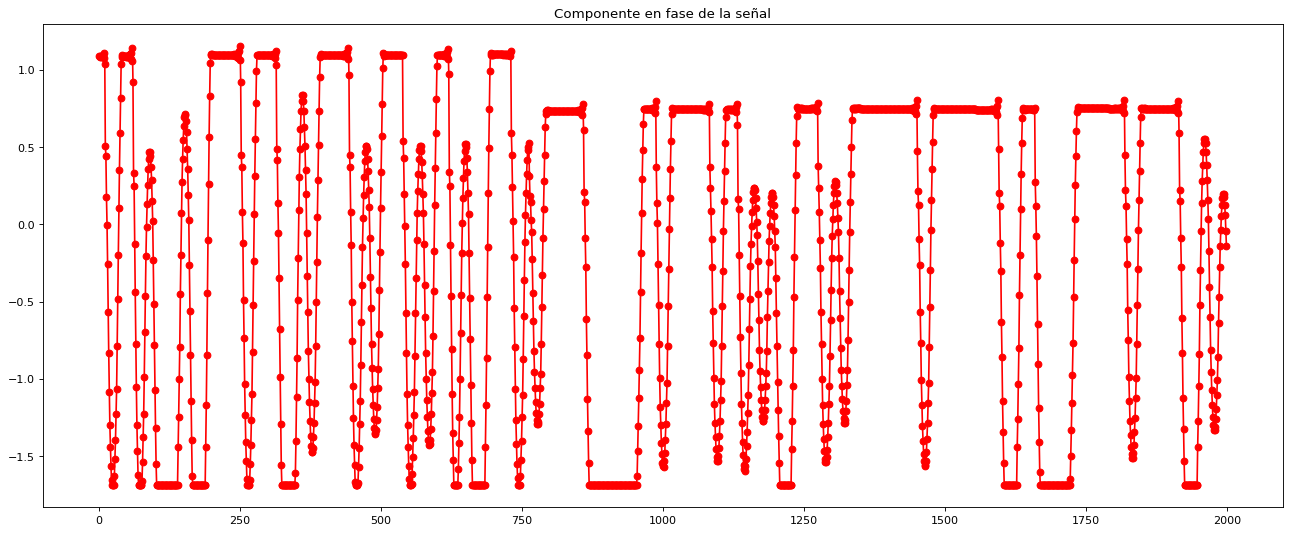

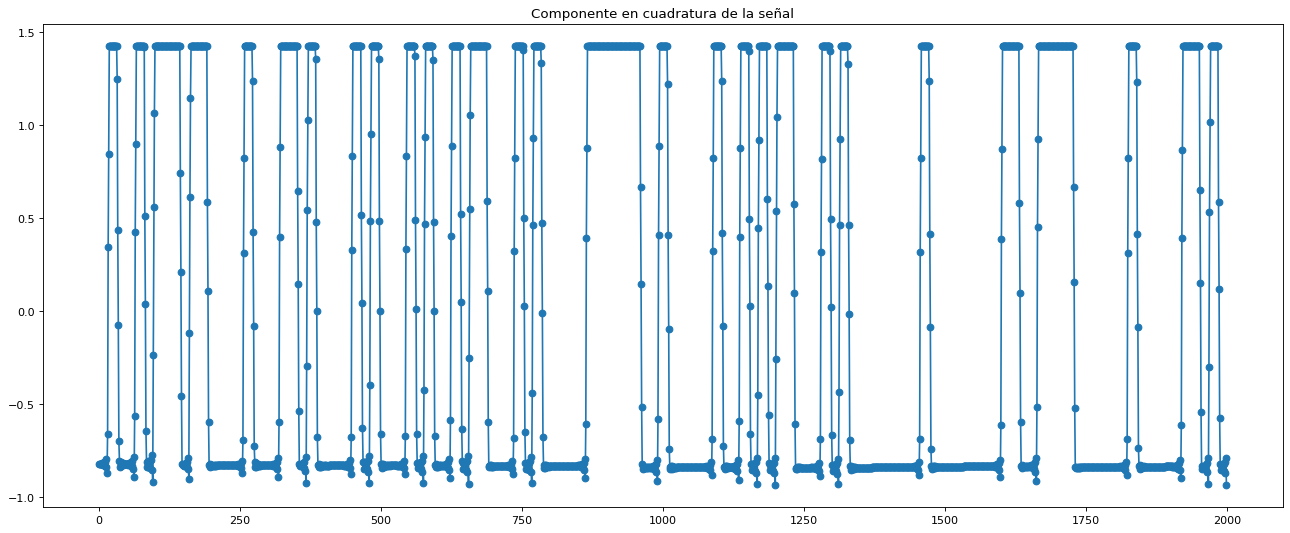

In [170]:
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(rxSignalRealN[0:2000],marker="o", color='r')
plt.title("Componente en fase de la señal")
plt.show()

plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(rxSignalImagN[0:2000],marker="o")
plt.title("Componente en cuadratura de la señal")
plt.show()

### Grafica en frecuencia de la señal recibida
Se grafica la densidad espectral de potencia de la señal recibida

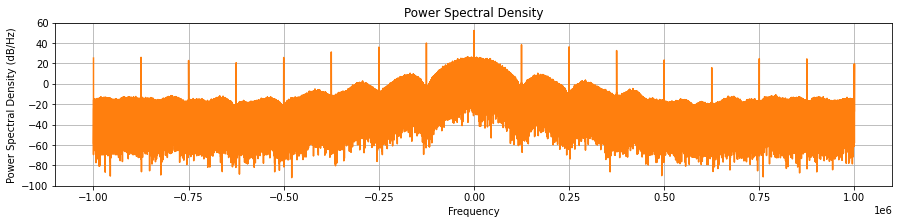

In [171]:
plotSpect(rxSignal,samplingRate)

### Histograma de la señal recibida
Realizamos el histograma de la señal normalizada, tanto de la parte real como imaginaria:

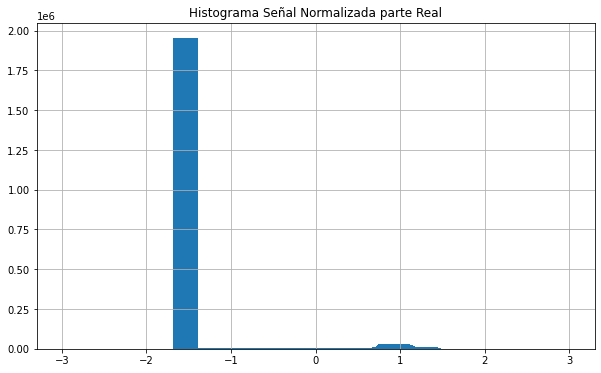

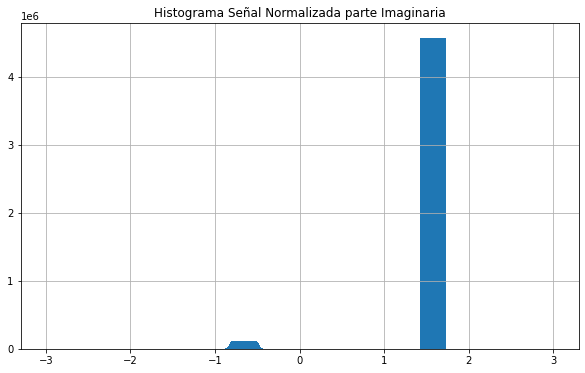

In [172]:
plt.figure(figsize=(10, 6))
plt.hist(rxSignalRealN,bins=10000,width=0.3,range=(-3,3))
plt.title("Histograma Señal Normalizada parte Real")
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(rxSignalImagN,bins=10000,width=0.3,range=(-3,3))
plt.title("Histograma Señal Normalizada parte Imaginaria")
plt.grid()
plt.show()

### Coclusiones al cambiar el nivel de decisión
Al cambiar el nivel de decisión podemos ver lo siguiente:
- En la grafica temporal podemos verificar nuestro generador esta enviando más ceros tanto en la parte real como imaginaria. En la última ejecución en la parte real esto no se esta pudiendo apreciar.
- En el grafico de frecuencia se lo puede visualizar con menor densidad espectral, no solo una pérdida de componentes armónicas, si no que tambien con menos frecuencia.
- Y en el histogramas vemos como en la parte real esta centrado en $-1$ aproximadamente, y en la parte imaginaria en $1$

## Cambio en el nivel de decisión y aumento de la potencia transmitida
Limpiamos nuevamente el buffer del transmisor, para que transmita con otra configuración:

In [173]:
sdr.tx_destroy_buffer()
sdr.tx_cyclic_buffer = tx_cyclic_buffer

Configuramos el SDR de la siguiente manera:

In [174]:
TxAtten          = -10              # Attenuation applied to TX path, valid range is -89 to 0 dB [dB]
sdr.tx_hardwaregain_chan0 = TxAtten  

### Transmisión
Se transmite:

In [175]:
#------------------------ Transmitter ------------------------------- 
sdr.tx(txSignal*(2**15-1)) # The PlutoSDR expects samples to be between -2^15-1 and +2^15-1, not -1 and +1 like some SDRs

### Recepción
Recibimos la señal nuevamente:

In [176]:
#Clear RX Buffer
for i in range(10):
    raw_data = sdr.rx()
    
#------------------------------- Receiver ------------------------------- 
rxSignal = sdr.rx()

### Normalización
Normailizamos la señal recibida para que tenga potencia unitaria.

In [177]:
desviacionReal = rxSignal.real.std()
print("Desviacion Real: ", desviacionReal)

desviacionImag = rxSignal.imag.std()
print("Desviacion Imaginaria: ",desviacionImag)

rxSignalRealN = rxSignal.real/desviacionReal
rxSignalImagN = rxSignal.imag/desviacionImag

Desviacion Real:  1469.0882059881283
Desviacion Imaginaria:  1434.2375973965438


### Grafica temporal de la señal recibida
Se gafica la señal recibida en el dominio del tiempo, vemos su parte real e imaginaria:

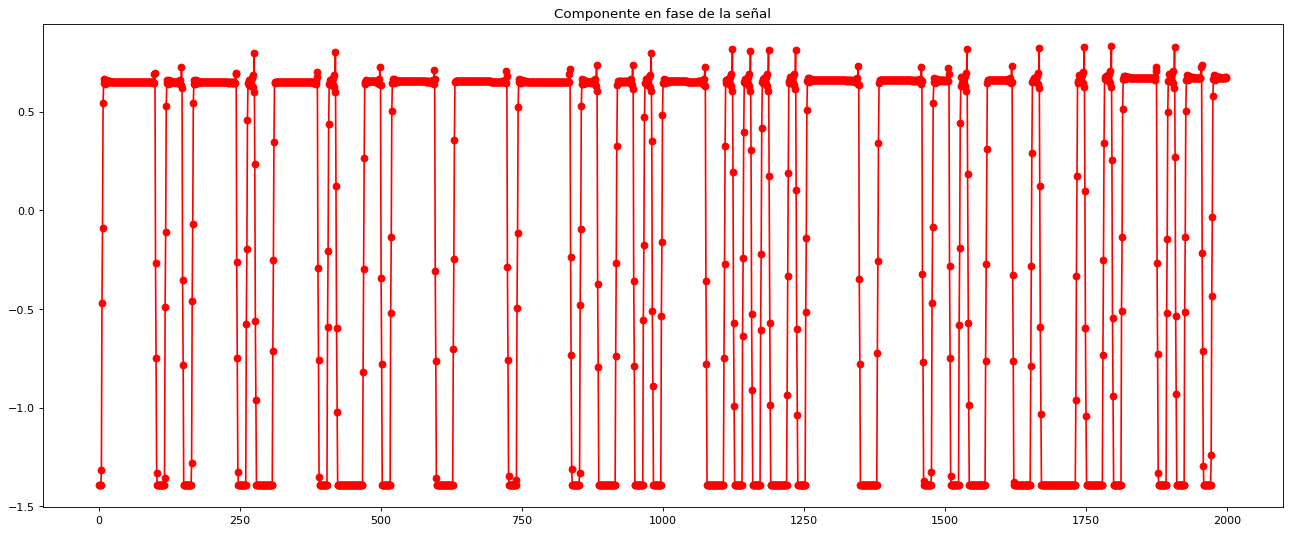

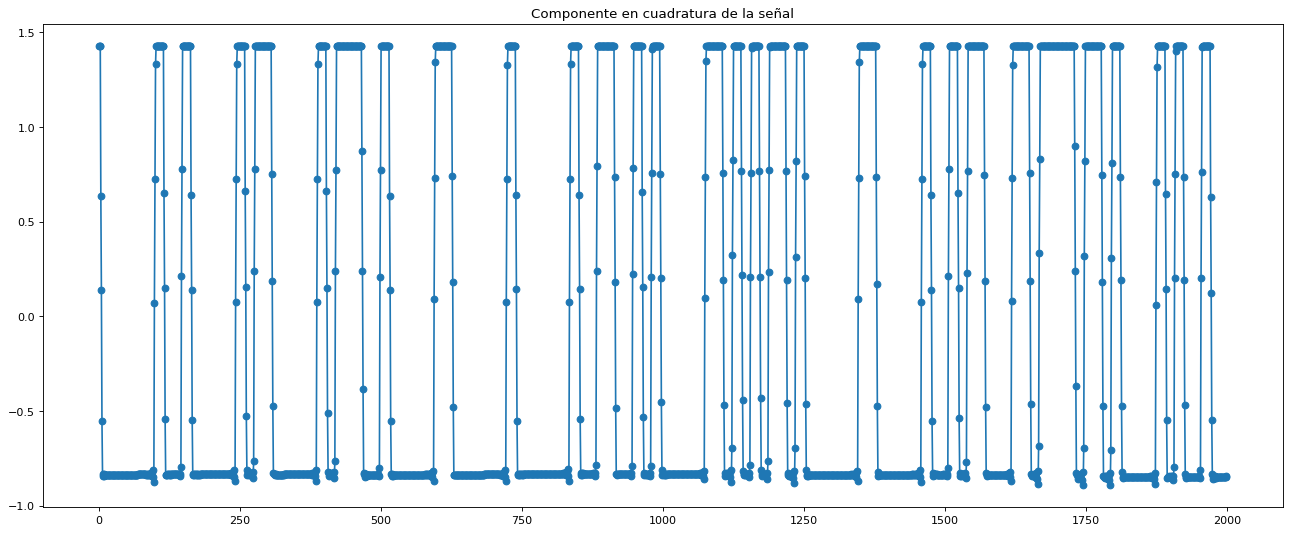

In [178]:
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(rxSignalRealN[0:2000],marker="o", color='r')
plt.title("Componente en fase de la señal")
plt.show()

plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(rxSignalImagN[0:2000],marker="o")
plt.title("Componente en cuadratura de la señal")
plt.show()

### Grafica en frecuencia de la señal recibida
Se grafica la densidad espectral de potencia de la señal recibida

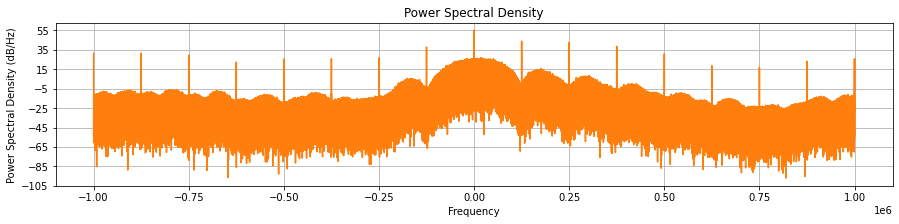

In [179]:
plotSpect(rxSignal,samplingRate)

### Histograma de la señal recibida
Realizamos el histograma de la señal normalizada, tanto de la parte real como imaginaria:

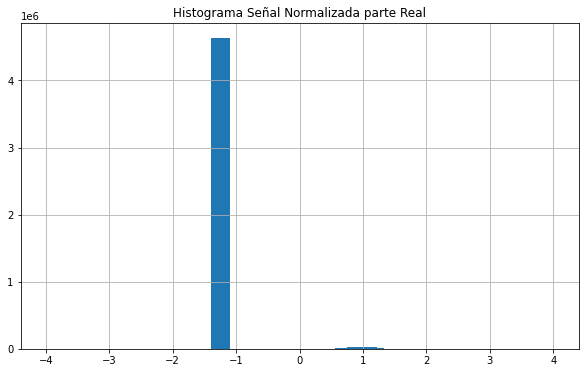

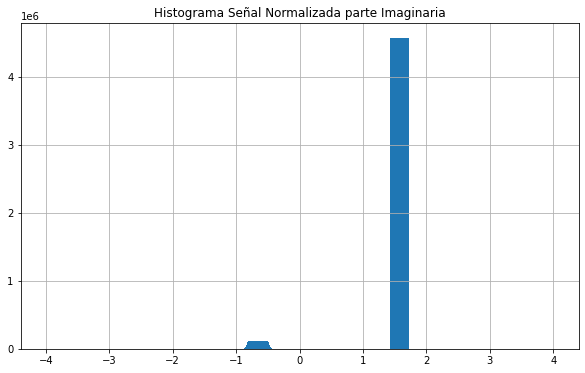

In [180]:
plt.figure(figsize=(10, 6))
plt.hist(rxSignalRealN,bins=15000,width=0.3,range=(-4,4))
plt.title("Histograma Señal Normalizada parte Real")
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(rxSignalImagN,bins=15000,width=0.3,range=(-4,4))
plt.title("Histograma Señal Normalizada parte Imaginaria")
plt.grid()
plt.show()

### Coclusiones al cambiar el nivel de decisión y la potencia
Al cambiar el nivel de decisión podemos ver lo siguiente:
- En la grafica temporal podemos verificar nuestro generador esta enviando más ceros tanto en la parte real como imaginaria.
- En el grafico de frecuencia se lo puede visualizar con una pérdida de componentes armónicas. Comparandolo con el gráfico de densidad espectral para cuando solo se cambia el nivel de decisión, justamente este tiene mayor potencia
- Y la menor frecuencia de que la señal tome valores tambien se lo puede apreciar en el histograma, pero con un poco mayor de definción ya que tiene menos atenuación.

## Hipotensis cuaternarias
Se realiza el siguiente código para enviar una hipotesís $H \in \{ -1, -0.3333, +0.3333, 1 \}$ con iguales probabilidades:

In [181]:
# Parámetros
ref = 0.5                              # Probabilidad de ocurrencia - equiprobable
hipotesis = [-1, -0.3333, 0.3333, 1]   # Valores de la hipótesis

# Generar señales binarias
z = np.random.uniform(size=nSamples)   # Generador uniforme de números aleatorios
x = [1 if z[i] > ref else 0 for i in range(len(z))]  # Vector binario de acuerdo a la probabilidad de ocurrencia 

# Asignar valores según la hipótesis
txSignal = np.zeros(nSamples, dtype=complex)  # Inicializar señal binaria compleja

for i in range(0, nSamples, 2**4):
    index = np.random.choice(len(hipotesis))               # Elegir aleatoriamente un valor de la hipótesis
    index1 = np.random.choice(len(hipotesis))
    txSignal[i:i+2**4] = np.repeat(hipotesis[index] + 1j*hipotesis[index1], 2**4)  # Asignar el valor correspondiente

### Gráfica temporal de la señal recibida
En este punto se busca graficar la parte real e imaginaria de la señal que se va a transmitir, para ello se define la siguiente función:

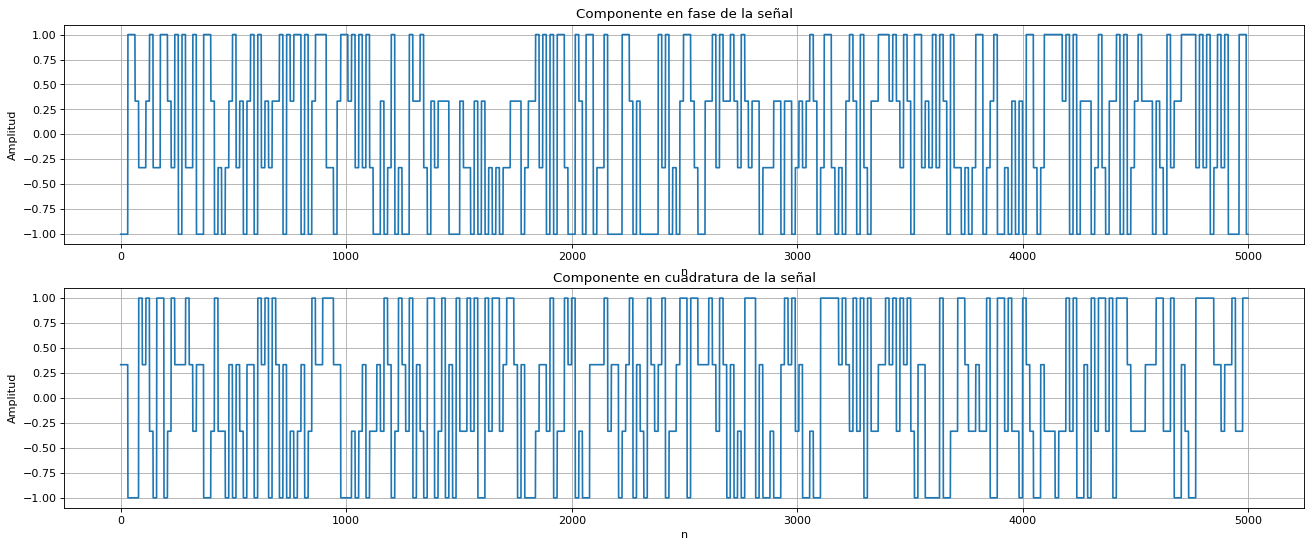

In [182]:
plotSignal(txSignal[0:5000])

### Grafica en frecuencia de la señal
Graficamos la densidad espectral:

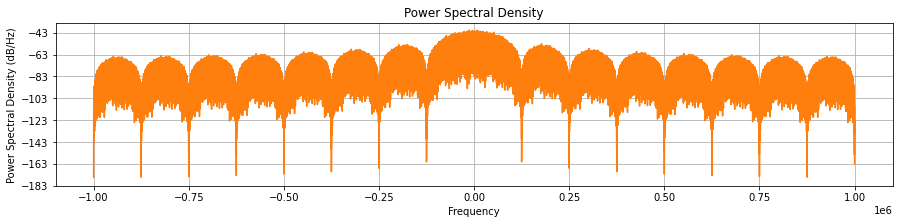

In [183]:
plotSpect(txSignal,samplingRate)

### Histograma de la señal
Graficamos el histograma de la señal para ver las componenentes de la señal.

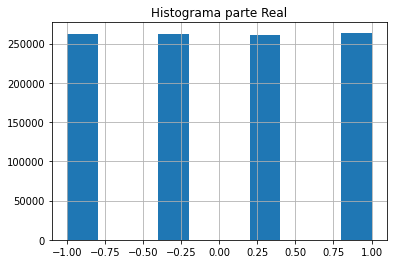

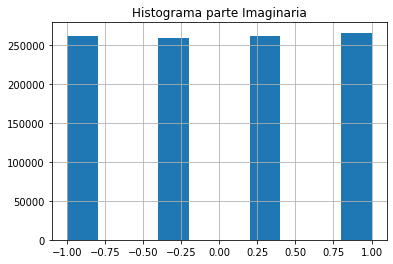

In [184]:
plt.hist(txSignal.real)
plt.grid()
plt.title("Histograma parte Real")
plt.show()

plt.hist(txSignal.imag)
plt.title("Histograma parte Imaginaria")
plt.grid()
plt.show()

### Transmisión
Limpiamos el buffer del transmisor, para que transmita con otra configuración: 

In [195]:
sdr.tx_destroy_buffer()
sdr.tx_cyclic_buffer = tx_cyclic_buffer

Configuramos el SDR de la siguiente manera:

In [196]:
TxAtten          = -5            # Attenuation applied to TX path, valid range is -89 to 0 dB [dB]
sdr.tx_hardwaregain_chan0 = TxAtten 

Transmitimos:

In [197]:
#----------------- Transmitter ------------------------------- 
sdr.tx(txSignal*(2**15-1)) # The PlutoSDR expects samples to be between -2^15-1 and +2^15-1, not -1 and +1 like some SDRs

### Recepción
Recibimos la señal nuevamente:

In [198]:
#Clear RX Buffer
for i in range(10):
    raw_data = sdr.rx()
    
#------------------------------- Receiver ------------------------------- 
rxSignal = sdr.rx()

### Normalización
Normailizamos la señal recibida para que tenga potencia unitaria.

In [199]:
desviacionReal = rxSignal.real.std()
print("Desviacion Real: ", desviacionReal)

desviacionImag = rxSignal.imag.std()
print("Desviacion Imaginaria: ",desviacionImag)

rxSignalRealN = rxSignal.real/desviacionReal
rxSignalImagN = rxSignal.imag/desviacionImag

Desviacion Real:  1798.4571231181235
Desviacion Imaginaria:  1832.0086276706197


### Grafica temporal de la señal recibida
Se gafica la señal recibida en el dominio del tiempo, vemos su parte real e imaginaria:

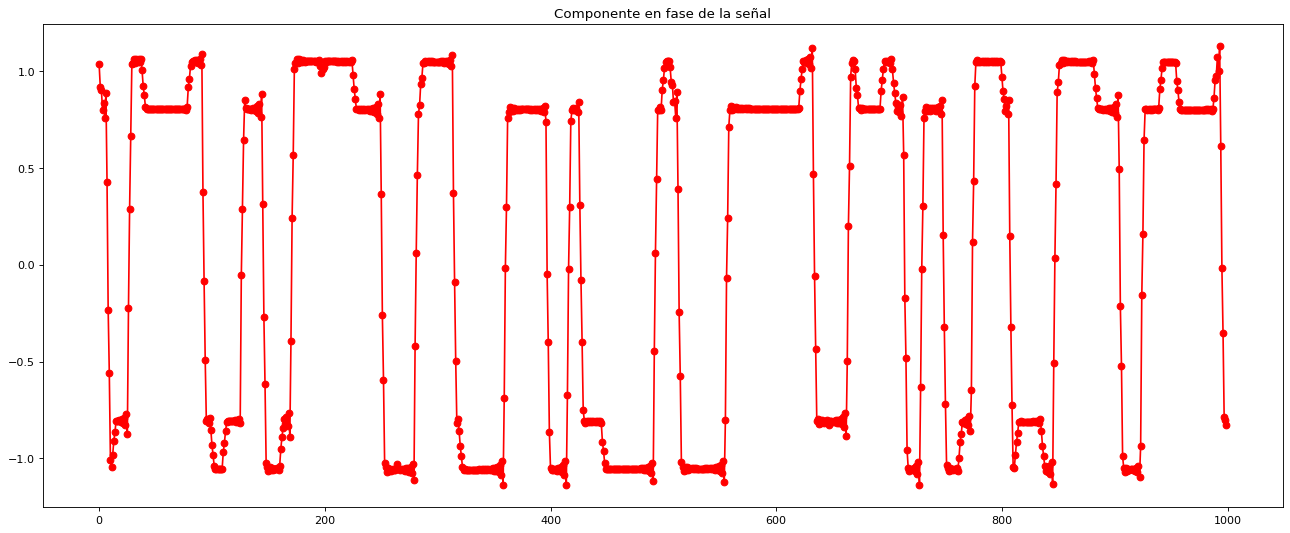

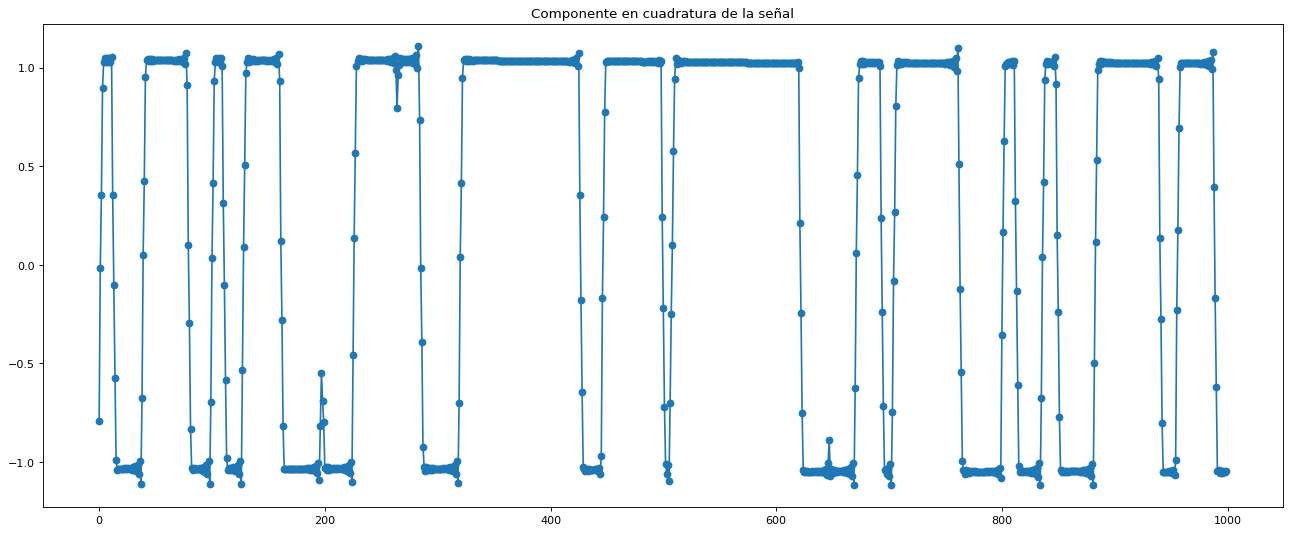

In [200]:
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(rxSignalRealN[2000:3000],marker="o", color='r')
plt.title("Componente en fase de la señal")
plt.show()

plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(rxSignalImagN[2000:3000],marker="o")
plt.title("Componente en cuadratura de la señal")
plt.show()

### Grafica en frecuencia de la señal recibida
Se grafica la densidad espectral de potencia de la señal recibida

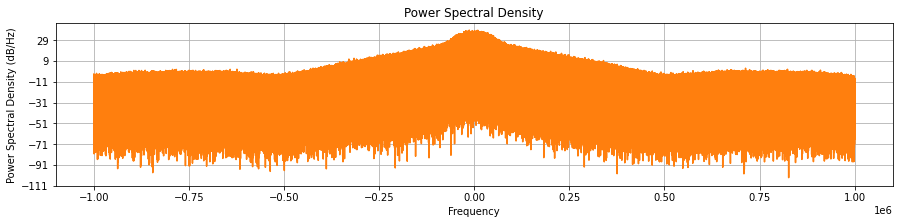

In [202]:
plotSpect(rxSignal,samplingRate)

### Histograma de la señal recibida
Realizamos el histograma de la señal normalizada, tanto de la parte real como imaginaria:

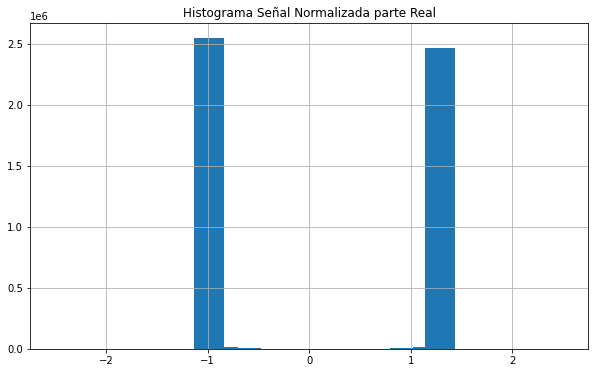

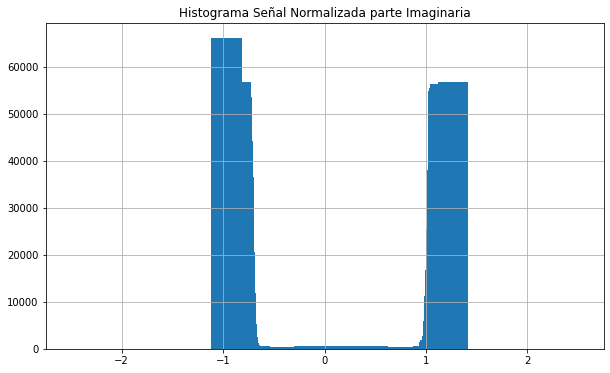

In [203]:
plt.figure(figsize=(10, 6))
plt.hist(rxSignalRealN,bins=10000,width=0.3,range=(-2.5,2.5))
plt.title("Histograma Señal Normalizada parte Real")
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(rxSignalImagN,bins=10000,width=0.3,range=(-2.5,2.5))
plt.title("Histograma Señal Normalizada parte Imaginaria")
plt.grid()
plt.show()

### Coclusiones al transmitir cuatro hipotesís
Al aumentar el número de hipotesís podemos ver lo siguiente:
- En la grafica temporal podemos verificar que nuestro generador esta enviando aproximandamente 4 valores picos diferentes.
- En el grafico de frecuencia se lo puede visualizar con cierta semejanza al ruido, ya que tiene media cero y una gran cantidad de armónicas.
- Y en el histograma, podemos ver solo dos picos tanto en la parte real como imaginaria, aunque se esperaría ver cuatro picos centrados en $-1$, $1$, $-0.333$, $0.333$ 

## Transmisión con máxima atenuación

Dado que no es posible apagar la etapa transmisora del SDR, es recomendable antes de finalizar la experiencia, dejar configurado el transmisor con la máxima atenuación posible, asegurarse que las frecuencias de transmisión y recepción no coinciden y cargar al Buffer transmisor con ceros. Esto permitirá minimizar cualquier posible interferencia por parte del SDR.

In [204]:
# Since it is not possible to turn off Tx, it is configured to transmit at low power and on a different frequency than Rx.
sdr.tx_destroy_buffer()
sdr.tx_hardwaregain_chan0 = -89 
sdr.tx_lo                 = int(2400e6)
sdr.rx_lo                 = int(950e6)
sdr.tx(np.zeros(2048))

# Destroy radio object
del(sdr)